In [775]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [776]:
from typing import Optional, Callable, List, Dict
import sys
import logging

import ipywidgets as widgets
import numpy as np
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('..')

In [777]:
from src.data import load_data
from src import config
from src.preprocessing.dataset import generate_dataset, get_is_day
from src.preprocessing.aoi import get_aoi_year_location

In [778]:
PERIOD = 96

LOC_X = 200
LOC_Y = 200

YEAR_TRAIN = 2020
YEAR_TEST = 2019

DATASET_SIZE = -1
NUMBER_TO_GENERATE = PERIOD * 20
SHIFT_SIZE = PERIOD * 2

ADD_IS_DAY = True
ADD_AOI = True
REMOVE_0 = True

In [779]:
assert DATASET_SIZE > NUMBER_TO_GENERATE + SHIFT_SIZE or DATASET_SIZE==-1

train_data = load_data("../data", YEAR_TRAIN)[:DATASET_SIZE, LOC_X, LOC_Y]
test_data = load_data("../data", YEAR_TEST)[:DATASET_SIZE, LOC_X, LOC_Y]


print(train_data.shape, test_data.shape)

(35135,) (35039,)


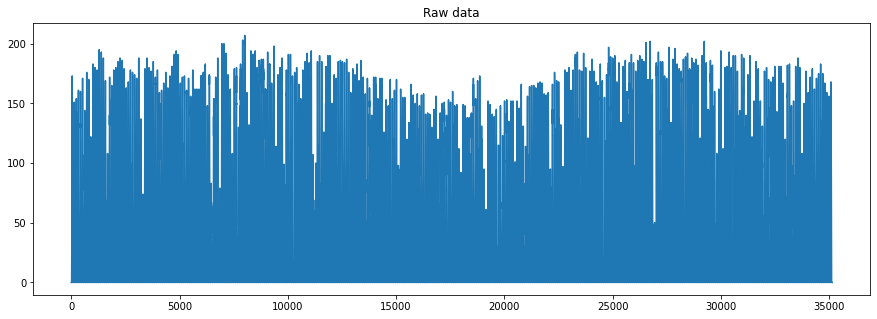

In [780]:
plt.figure(figsize=(15,5))
plt.plot(train_data)
plt.title('Raw data')
plt.show()

In [781]:
# Original X_train and X_test
X_train, y_train, train_indexes = generate_dataset(train_data, shift=SHIFT_SIZE, make_diff=False, remove_some_0=REMOVE_0)
X_test, y_test, test_indexes = generate_dataset(test_data, shift=SHIFT_SIZE, make_diff=False,remove_some_0=False)


# Compute the IS DAY 
if ADD_IS_DAY:
    print("Adding is day...")
    train_is_day = get_is_day(size=train_data.shape[0], shift=SHIFT_SIZE)
    test_is_day = get_is_day(size=test_data.shape[0], shift=SHIFT_SIZE)

    if train_indexes is not None:
        train_is_day = train_is_day[train_indexes]
    if test_indexes is not None:
        test_is_day = test_is_day[test_indexes]
    print("train is_day shape", train_is_day.shape)
    print("test is_day shape", test_is_day.shape)
else:
    train_is_day = None
    test_is_day = None

# Compute the AOI
if ADD_AOI:
    print("Adding AOI...")
    train_aoi = get_aoi_year_location(LOC_X, LOC_Y, YEAR_TRAIN, SHIFT_SIZE)
    test_aoi = get_aoi_year_location(LOC_X, LOC_Y, YEAR_TEST, SHIFT_SIZE)
    if train_indexes is not None:
        train_aoi = train_aoi[train_indexes]
    if test_indexes is not None:
        test_aoi = test_aoi[test_indexes]

    print("train AOI", train_aoi.shape)
    print("test AOI", test_aoi.shape)
else:
    train_aoi = None
    test_aoi = None

print("train", X_train.shape, y_train.shape)
print("test", X_test.shape, y_test.shape)


Adding is day...
train is_day shape (19130,)
test is_day shape (34847,)
Adding AOI...
train AOI (19130,)
test AOI (34847,)
train (19130, 192) (19130,)
test (34847, 192) (34847,)


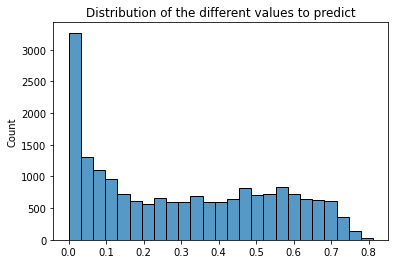

In [782]:
plt.figure()
plt.title('Distribution of the different values to predict')
sns.histplot(y_train);

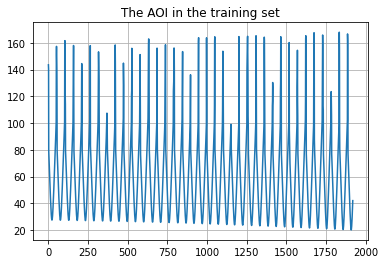

In [783]:
if train_aoi is not None:
    plt.figure()
    plt.title('The AOI in the training set')
    plt.plot(range(NUMBER_TO_GENERATE), train_aoi[:NUMBER_TO_GENERATE])
    plt.grid()
    plt.show()

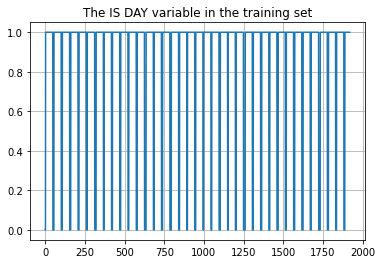

In [784]:
if train_is_day is not None:
    plt.figure()
    plt.title('The IS DAY variable in the training set')
    plt.plot(range(NUMBER_TO_GENERATE), train_is_day[:NUMBER_TO_GENERATE])
    plt.grid()
    plt.show()

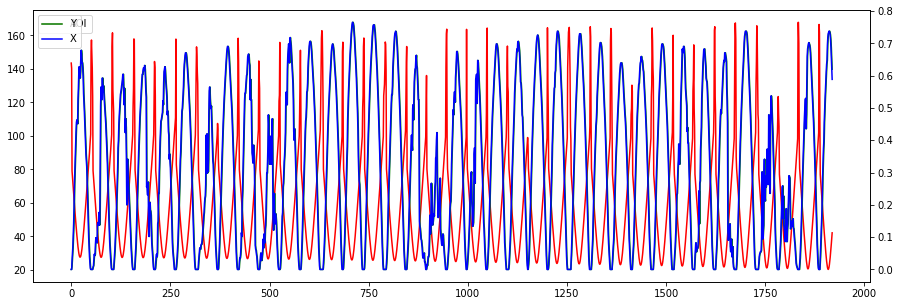

In [785]:
if ADD_AOI:
    fig, ax1 = plt.subplots(figsize=(15,5))

    ax1.plot(train_aoi[:NUMBER_TO_GENERATE], label="AOI", color="red")
    plt.legend()
    ax2 = ax1.twinx()
    ax2.plot(y_train[:NUMBER_TO_GENERATE], label="Y", color="green")
    ax2.plot(X_train[:NUMBER_TO_GENERATE,-1], label="X", color="blue")
    plt.legend()
    plt.show()

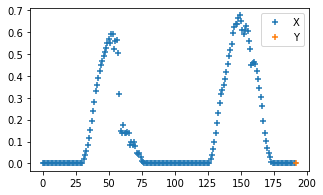

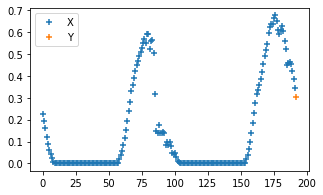

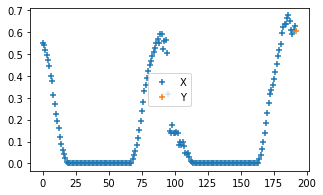

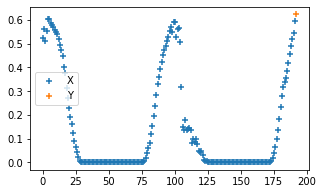

In [786]:
step = 10
for i, (x, y) in enumerate(zip(X_train, y_train)):
    if i % step != 0:
        continue
    plt.figure(figsize=(5, 3))
    plt.scatter(np.array(range(x.shape[0])), x, label="X", marker="+")
    plt.scatter([x.shape[0]], y, label="Y", marker="+")
    plt.legend()
    plt.title(f"")
    if i > step * 2:
        break


## Model

In [787]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor

In [788]:
class DummyModel():
    def fit(self, *args, **kwargs):
        pass

    def predict(self, X):
        return X[:,-PERIOD]

In [789]:
models = {
    #"LinearRegression": LinearRegression(),
    #"DecisionTreeRegressor": DecisionTreeRegressor(max_depth=2),
    "DecisionTreeRegressor2": DecisionTreeRegressor(max_depth=10),
    "DecisionTreeRegressor3": DecisionTreeRegressor(max_depth=100),
    "DecisionTreeRegressor4": DecisionTreeRegressor(max_depth=500),
    "PolynomialRegression": Pipeline([
        ('poly', PolynomialFeatures(degree=2)),
        ('linear', LinearRegression())
    ]),
    "neural_net": MLPRegressor(
        hidden_layer_sizes=(30, 30, 10, 1),
        activation="relu",
        solver="adam",
        learning_rate="constant",
        learning_rate_init=1e-3
    ),
    "dummy": DummyModel()
}

del models['PolynomialRegression'] # We don't want to test this one, goes to crazy

In [790]:
selection_checkboxes = [widgets.Checkbox(value=True, description=label) for label in models]
output = widgets.VBox(children=selection_checkboxes)
display(output)

In [791]:
selected_models = set([
    checkbox.description for checkbox in selection_checkboxes if checkbox.value
])
print(f"Running the evaluation with {', '.join(selected_models)}")

models = {k:v for k,v in models.items() if k in selected_models}

Running the evaluation with DecisionTreeRegressor4, dummy, neural_net, DecisionTreeRegressor2, DecisionTreeRegressor3


In [792]:
# Before the training, we will create the real input values that we will input in the mode

to_concatenate = [X_train]
if train_is_day is not None:
    to_concatenate.append(train_is_day.reshape((-1, 1)))
if train_aoi is not None:
    to_concatenate.append(train_aoi.reshape((-1, 1)))


X_train_ = np.concatenate(to_concatenate, axis=-1)


for model_name, model in models.items():
    print(model_name)
    model.fit(X_train_, y_train)
print('Done !')

DecisionTreeRegressor2
DecisionTreeRegressor3
DecisionTreeRegressor4
neural_net
dummy
Done !


In [793]:
IDX = 10

x_initial = X_test[IDX]
y_truth = y_test[IDX:IDX+NUMBER_TO_GENERATE]

# Check the sizes
assert x_initial.shape == (SHIFT_SIZE,), f"{x_initial.shape} != ({SHIFT_SIZE},)"
assert y_truth.shape == (NUMBER_TO_GENERATE,), f"{y_truth.shape} != ({NUMBER_TO_GENERATE},)"

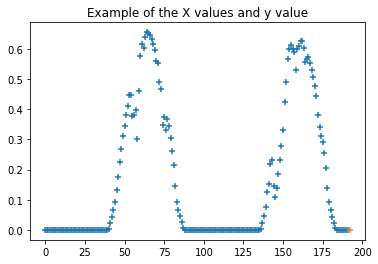

In [794]:
plt.scatter(range(x_initial.shape[0]), x_initial, marker="+")
plt.scatter([x_initial.shape[0]], y_truth[:1], marker="+")
plt.title("Example of the X values and y value")
plt.show();

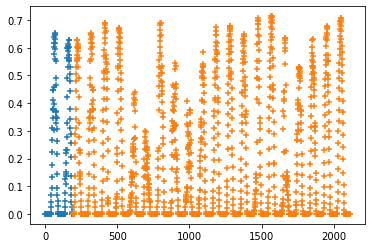

In [795]:
plt.figure()
plt.scatter(range(SHIFT_SIZE), x_initial[:SHIFT_SIZE], marker="+")
plt.scatter(range(SHIFT_SIZE, SHIFT_SIZE+NUMBER_TO_GENERATE), y_truth[:NUMBER_TO_GENERATE], marker="+")
plt.show()

100%|██████████| 1920/1920 [00:00<00:00, 213060.92it/s]


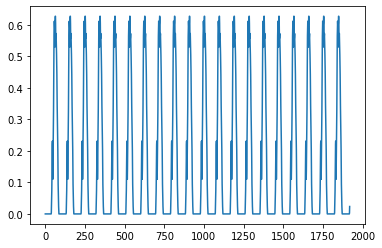

In [796]:
def predict_next_values(pred_func: Callable, x_initial: np.ndarray, how_many: int, is_day: np.ndarray, aoi_values: np.ndarray):
    """Predict the next values."""
    size = SHIFT_SIZE
    predictions = np.zeros((1, size+how_many))
    predictions[0,:size] = x_initial[-size:]
    
    try:
        for i in tqdm(range(how_many)):
            x = predictions[:,i:i+size]

            # If needed, we add the AOI and/or the is_day
            to_concat = [x[0]]
            if is_day is not None:
                to_concat.append(is_day[i:i+1])
            if aoi_values is not None:
                to_concat.append(aoi_values[i:i+1])
            if len(to_concat)>1:
                x = np.concatenate(to_concat, axis=-1).reshape((1, -1))

            
            predictions[0,size + i] = pred_func(x)[0]
    except Exception as e:
        print(e)
    return predictions[0,size:]

plt.plot(predict_next_values(models['dummy'].predict, x_initial, NUMBER_TO_GENERATE, test_is_day, test_aoi));

In [814]:
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

def plot_prediction_and_metrics(x_initial: np.ndarray, y_truth: np.ndarray, y_preds: Dict[str, np.ndarray], offset=12):
    """Plot the prediction."""
    plt.figure(figsize=(30, 10))
    plt.ylim(-0.2, 1.1)
    plt.plot(x_initial[:SHIFT_SIZE], label="Initial values", marker="+")
    idx = np.array(range(SHIFT_SIZE, SHIFT_SIZE + y_truth.shape[0]))
    plt.plot(idx, y_truth, label="Truth", marker="+")
    
    results = {}
    for model_name, y_pred in y_preds.items():
        results[model_name] = {
            "mse": mean_squared_error(y_truth[:-offset], y_pred[offset:]),
            "mae": mean_absolute_error(y_truth[:-offset], y_pred[offset:]),
            "r2": r2_score(y_truth[:-offset], y_pred[offset:])
        }
        plt.plot(idx[:-offset], y_pred[offset:], label=f"Prediction with {model_name}", marker="+")

    plt.grid()
    plt.legend()
    plt.savefig('../docs/model_predictions.png', transparent=True)
    plt.show()
    return results


In [815]:
print('Predictions to display')
pred_checkboxes = [widgets.Checkbox(value=True, description=label) for label in models]
output = widgets.VBox(children=pred_checkboxes)
display(output)

Predictions to display


In [816]:
selected_models = set([
    checkbox.description for checkbox in pred_checkboxes if checkbox.value
])
print(f"Prediction and display the following models: {', '.join(selected_models)}")

Prediction and display the following models: DecisionTreeRegressor4, dummy, neural_net, DecisionTreeRegressor2, DecisionTreeRegressor3


In [817]:
predictions = {
    model_name: predict_next_values(
        pred_func=model.predict, x_initial=x_initial, how_many=NUMBER_TO_GENERATE,
        is_day=test_is_day, aoi_values=test_aoi
            
    )
    for model_name, model in models.items()
    if model_name in selected_models
}

100%|██████████| 1920/1920 [00:00<00:00, 234748.98it/s]


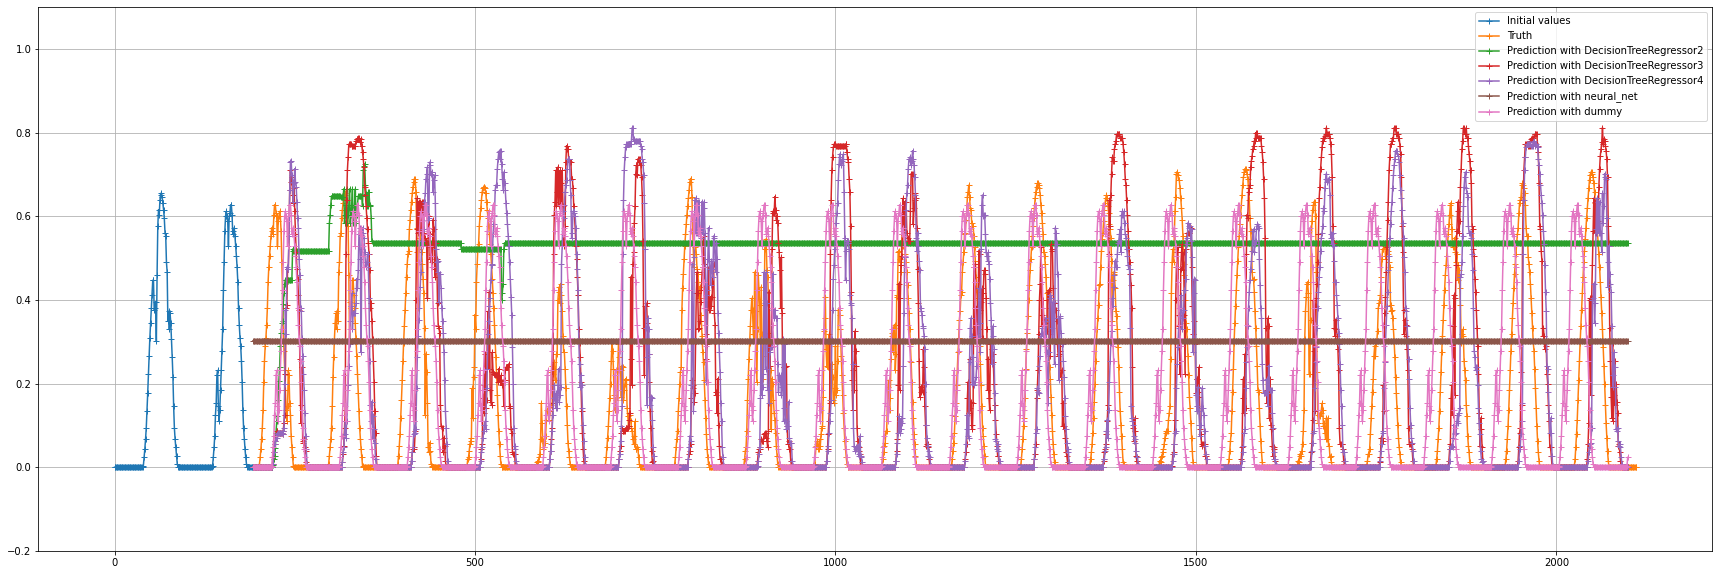

In [818]:
results = plot_prediction_and_metrics(
    x_initial,
    y_truth,
    predictions
)


In [802]:
pd.DataFrame(results)

,DecisionTreeRegressor2,DecisionTreeRegressor3,DecisionTreeRegressor4,neural_net,dummy
mse,0.192643,0.096719,0.099492,0.068721,0.047242
mae,0.397519,0.212944,0.220693,0.245143,0.134365
r2,-3.047190,-1.031951,-1.090201,-0.443744,0.007497


# Models explicability

In [803]:
MODEL_NAME = "DecisionTreeRegressor3"

In [804]:
model = models[MODEL_NAME]

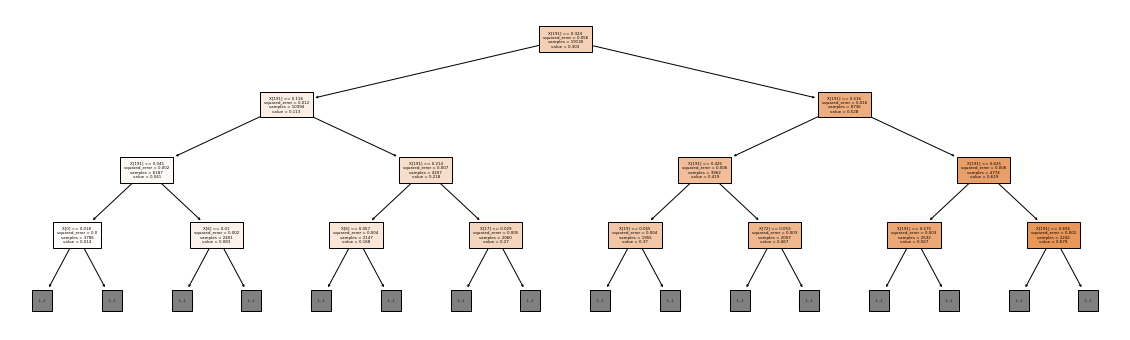

In [805]:
if isinstance(model, DecisionTreeRegressor):
    # plot model decision tree
    from sklearn.tree import plot_tree

    plt.figure(figsize=(20,6))
    plot_tree(model, filled=True, max_depth=3, fontsize=4)
    plt.savefig(f'./model_tree_{MODEL_NAME}.png')
    plt.show()

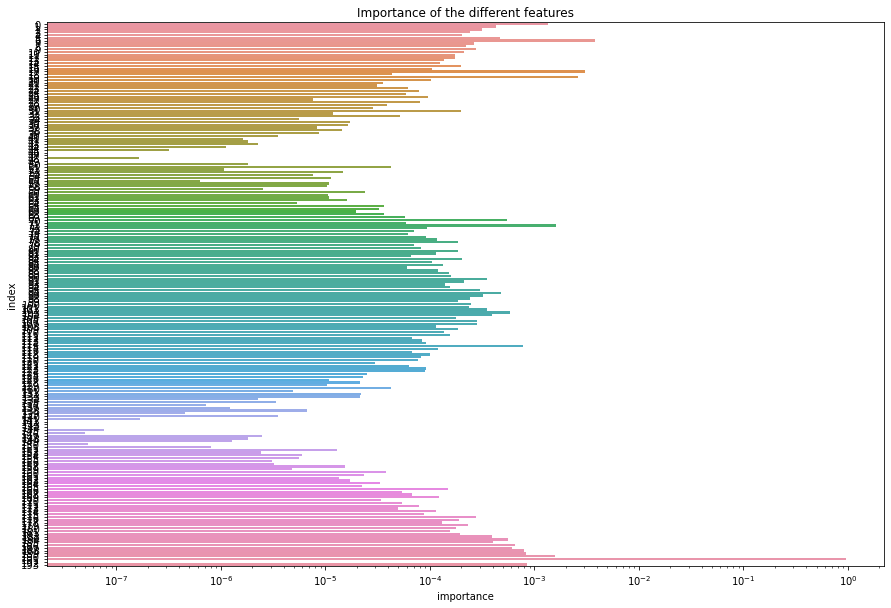

In [806]:
if isinstance(model, DecisionTreeRegressor):
    df = pd.DataFrame({
        "importance": model.feature_importances_
    }).reset_index()
    plt.figure(figsize=(15,10))
    sns.barplot(
        data=df,
        y="index",
        x="importance",
        orient="h"
    );
    plt.title('Importance of the different features')
    # set log y axis
    plt.xscale("log")

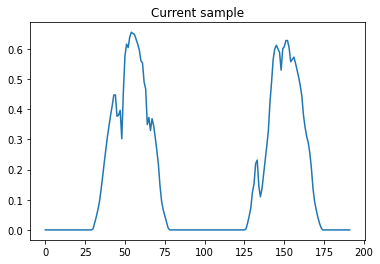

In [807]:
plt.plot(X_test[0])
plt.title('Current sample')
plt.show()

In [808]:
IDX = 0
to_concat = [X_test[IDX]]
if test_is_day is not None:
    to_concat.append(test_is_day[IDX:IDX+1])
if test_aoi is not None:
    to_concat.append(test_aoi[IDX:IDX+1])
x_sample = np.concatenate(to_concat, axis=-1)
x_sample.shape

(194,)

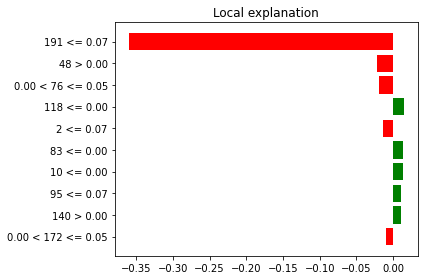

In [809]:
import lime
from lime import lime_tabular
import numpy as np

explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train_,
    mode="regression",
)


exp = explainer.explain_instance(x_sample, predict_fn=model.predict)

exp.as_pyplot_figure()
import matplotlib.pyplot as plt
plt.tight_layout()

  0%|          | 0/40 [00:00<?, ?it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  2%|▎         | 1/40 [00:00<00:29,  1.31it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(

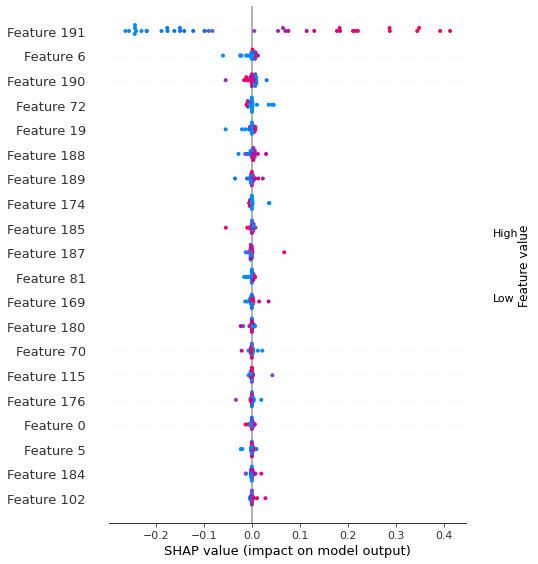

In [810]:
import shap
train = shap.sample(X_train_,40)
shap_explainer = shap.KernelExplainer(model.predict, train)
shap_values = shap_explainer.shap_values(train)
shap.summary_plot(shap_values, train)

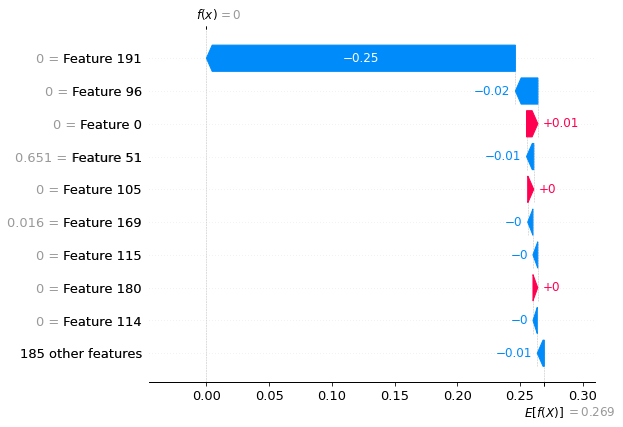

In [811]:
shap_explainer = shap.Explainer(model.predict, train)
shap_values = shap_explainer(train)
shap.plots.waterfall(shap_values[0])

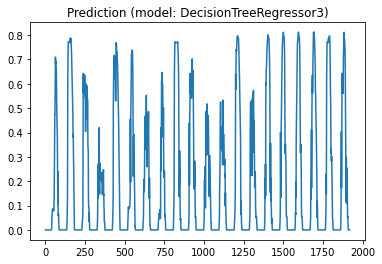

In [812]:
prediction = predictions[MODEL_NAME]
plt.figure()
plt.title(f"Prediction (model: {MODEL_NAME})")
plt.plot(prediction);

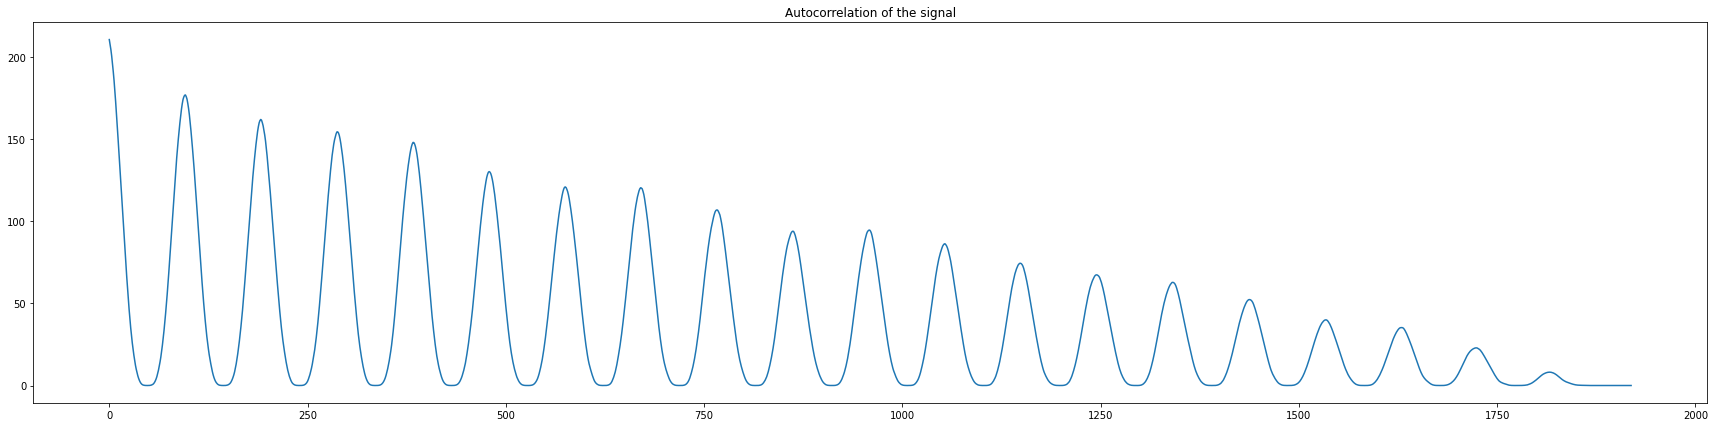

In [813]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[len(result)//2:]

corr = autocorr(prediction)
plt.figure(figsize=(30,7))
plt.title('Autocorrelation of the signal')
plt.plot(corr)
plt.show()